In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
'''
Here, we built the new dataset manually and also wanted to remap the classes. In some cases, it may be enough
to take a subset of the indices of a given dataset. This can be accomplished using the torch.utils
.data.Subset class. Similarly, there is ConcatDataset to join datasets (of compatible items) into a larger
one. For iterable datasets, ChainDataset gives a larger, iterable dataset.
'''
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
# training
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
# validation
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
import torch.nn as nn
# How many features per sample? Well, 32 × 32 × 3: that is, 3,072 input features per sample
n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1> features
                512,   # <2> hidden layer
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2> hidden layer
                n_out, # <3> 
            )
        )

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
# Since, as usual, input tensors may have an additional batch 0th dimension, or have dimensions along which they
# encode probabilities and others in which they don’t, nn.Softmax requires us to specify
# the dimension along which the softmax function is applied
softmax = nn.Softmax(dim=1)

# In this case, we have two input vectors in two rows (just like when we work with
#batches), so we initialize nn.Softmax to operate along dimension 1
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [11]:
# update the model to produce probabilities
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


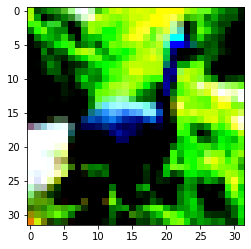

In [12]:
'''
try running the model before even training it. Let’s do it, just to see
what comes out. We first build a batch of one image, our bird
'''
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
'''
We recall that our model expects 3,072 features in the input, and that nn
works with data organized into batches along the zeroth dimension. So we need to
turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the
zeroth position
'''
img_batch = img.view(-1).unsqueeze(0)

In [14]:
'''
So, we got probabilities! Well, we know we shouldn’t get too excited: the weights and
biases of our linear layers have not been trained at all. Their elements are initialized
randomly by PyTorch between –1.0 and 1.0. Interestingly, we also see grad_fn for the
output, which is the tip of the backward computation graph (it will be used as soon as
we need to backpropagate).
'''
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
#we need to take the max along the probability vector (not across batches), therefore, dimension 1
_, index = torch.max(out, dim=1)

index

tensor([1])

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [21]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [22]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [23]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [24]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [25]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [27]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [28]:
log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [30]:
'''
taking the logarithm of a probability is tricky when the probability gets close to zero. The
workaround is to use nn.LogSoftmax instead of nn.Softmax , which takes care to make
the calculation numerically stable.
'''
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [31]:
# The loss takes the output of nn.LogSoftmax for a batch as the first argument and a
#tensor of class indices (zeros and ones, in our case) as the second argument
#img, label = cifar2[0]

loss = nn.NLLLoss()

In [32]:
# Test
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 8.307038
Epoch: 1, Loss: 5.457431
Epoch: 2, Loss: 3.882373
Epoch: 3, Loss: 3.154704
Epoch: 4, Loss: 11.443868
Epoch: 5, Loss: 7.831904
Epoch: 6, Loss: 0.055682
Epoch: 7, Loss: 7.118860
Epoch: 8, Loss: 6.412682
Epoch: 9, Loss: 5.462630
Epoch: 10, Loss: 6.324239
Epoch: 11, Loss: 8.132204
Epoch: 12, Loss: 4.478361
Epoch: 13, Loss: 0.397974
Epoch: 14, Loss: 3.924431
Epoch: 15, Loss: 6.191980
Epoch: 16, Loss: 4.834426
Epoch: 17, Loss: 6.948432
Epoch: 18, Loss: 0.884499
Epoch: 19, Loss: 10.726386
Epoch: 20, Loss: 8.787334
Epoch: 21, Loss: 5.266410
Epoch: 22, Loss: 7.096104
Epoch: 23, Loss: 4.407344
Epoch: 24, Loss: 6.470562
Epoch: 25, Loss: 10.756291
Epoch: 26, Loss: 16.045588
Epoch: 27, Loss: 13.241747
Epoch: 28, Loss: 8.135650
Epoch: 29, Loss: 9.221145
Epoch: 30, Loss: 11.256797
Epoch: 31, Loss: 13.286485
Epoch: 32, Loss: 14.590942
Epoch: 33, Loss: 19.243477
Epoch: 34, Loss: 7.613646
Epoch: 35, Loss: 8.939101
Epoch: 36, Loss: 5.921707
Epoch: 37, Loss: 7.737715
Epoch: 38, Lo

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.447263
Epoch: 1, Loss: 0.417204
Epoch: 2, Loss: 0.288800
Epoch: 3, Loss: 0.329748
Epoch: 4, Loss: 0.442465
Epoch: 5, Loss: 0.406243
Epoch: 6, Loss: 0.698463
Epoch: 7, Loss: 0.429398
Epoch: 8, Loss: 0.375769
Epoch: 9, Loss: 0.517260
Epoch: 10, Loss: 0.428689
Epoch: 11, Loss: 0.416207
Epoch: 12, Loss: 0.365555
Epoch: 13, Loss: 0.329109
Epoch: 14, Loss: 0.320614
Epoch: 15, Loss: 0.416643
Epoch: 16, Loss: 0.434464
Epoch: 17, Loss: 0.323721
Epoch: 18, Loss: 0.296406
Epoch: 19, Loss: 0.525408
Epoch: 20, Loss: 0.275151
Epoch: 21, Loss: 0.296652
Epoch: 22, Loss: 0.370118
Epoch: 23, Loss: 0.189625
Epoch: 24, Loss: 0.260521
Epoch: 25, Loss: 0.231848
Epoch: 26, Loss: 0.109705
Epoch: 27, Loss: 0.537065
Epoch: 28, Loss: 0.154275
Epoch: 29, Loss: 0.526165
Epoch: 30, Loss: 0.219033
Epoch: 31, Loss: 0.316020
Epoch: 32, Loss: 0.287425
Epoch: 33, Loss: 0.222993
Epoch: 34, Loss: 0.198543
Epoch: 35, Loss: 0.110400
Epoch: 36, Loss: 0.185364
Epoch: 37, Loss: 0.136970
Epoch: 38, Loss: 0.430

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.257707
Epoch: 1, Loss: 0.410050
Epoch: 2, Loss: 0.353380
Epoch: 3, Loss: 0.491312
Epoch: 4, Loss: 0.255176
Epoch: 5, Loss: 0.425032
Epoch: 6, Loss: 0.407701
Epoch: 7, Loss: 0.562127
Epoch: 8, Loss: 0.359097
Epoch: 9, Loss: 0.499740
Epoch: 10, Loss: 0.318886
Epoch: 11, Loss: 0.962872
Epoch: 12, Loss: 0.314391
Epoch: 13, Loss: 0.348557
Epoch: 14, Loss: 0.364174
Epoch: 15, Loss: 0.305631
Epoch: 16, Loss: 0.305762
Epoch: 17, Loss: 0.414332
Epoch: 18, Loss: 0.223709
Epoch: 19, Loss: 0.299378
Epoch: 20, Loss: 0.278254
Epoch: 21, Loss: 0.164422
Epoch: 22, Loss: 0.155688
Epoch: 23, Loss: 0.285705
Epoch: 24, Loss: 0.173727
Epoch: 25, Loss: 0.205155
Epoch: 26, Loss: 0.329013
Epoch: 27, Loss: 0.536953
Epoch: 28, Loss: 0.233588
Epoch: 29, Loss: 0.320415
Epoch: 30, Loss: 0.205343
Epoch: 31, Loss: 0.249236
Epoch: 32, Loss: 0.358398
Epoch: 33, Loss: 0.204784
Epoch: 34, Loss: 0.139924
Epoch: 35, Loss: 0.125468
Epoch: 36, Loss: 0.088745
Epoch: 37, Loss: 0.184781
Epoch: 38, Loss: 0.103

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999400


In [38]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.814000


In [39]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [40]:
'''
It is quite common to drop the last nn.LogSoftmax layer from the network and use nn.CrossEntropyLoss as a loss.
See cell above to notice the change

Note that the numbers will be exactly the same as with nn.LogSoftmax and nn.NLLLoss .
It’s just more convenient to do it all in one pass, with the only gotcha being that the out-
put of our model will not be interpretable as probabilities (or log probabilities). We’ll
need to explicitly pass the output through a softmax to obtain those.

'''
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.427383
Epoch: 1, Loss: 0.453439
Epoch: 2, Loss: 0.451896
Epoch: 3, Loss: 0.340515
Epoch: 4, Loss: 0.379794
Epoch: 5, Loss: 0.489850
Epoch: 6, Loss: 0.359692
Epoch: 7, Loss: 0.419031
Epoch: 8, Loss: 0.267193
Epoch: 9, Loss: 0.722905
Epoch: 10, Loss: 0.305732
Epoch: 11, Loss: 0.682315
Epoch: 12, Loss: 0.348954
Epoch: 13, Loss: 0.599178
Epoch: 14, Loss: 0.922912
Epoch: 15, Loss: 0.221359
Epoch: 16, Loss: 0.519512
Epoch: 17, Loss: 0.324101
Epoch: 18, Loss: 0.237601
Epoch: 19, Loss: 0.285722
Epoch: 20, Loss: 0.247945
Epoch: 21, Loss: 0.473641
Epoch: 22, Loss: 0.171110
Epoch: 23, Loss: 0.217691
Epoch: 24, Loss: 0.373258
Epoch: 25, Loss: 0.336612
Epoch: 26, Loss: 0.277369
Epoch: 27, Loss: 0.515435
Epoch: 28, Loss: 0.124597
Epoch: 29, Loss: 0.040614
Epoch: 30, Loss: 0.275652
Epoch: 31, Loss: 0.188183
Epoch: 32, Loss: 0.183083
Epoch: 33, Loss: 0.254040
Epoch: 34, Loss: 0.119641
Epoch: 35, Loss: 0.094407
Epoch: 36, Loss: 0.280047
Epoch: 37, Loss: 0.093297
Epoch: 38, Loss: 0.064

In [42]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [72]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 3, 3, 3], but got 2-dimensional input of size [64, 3072] instead

In [71]:
# Number of params
sum([p.numel() for p in model.parameters()])

18090

In [45]:
'''
# counting parameters might require us to check whether a
#parameter has requires_grad set to True
In our full network,
we had 1,024 output features, which led the first linear module to have 3 million
parameters. This shouldn’t be unexpected: we know that a linear layer computes y =
weight * x + bias , and if x has length 3,072 (disregarding the batch dimension for
simplicity) and y must have length 1,024, then the weight tensor needs to be of size
1,024 × 3,072 and the bias size must be 1,024. And 1,024 * 3,072 + 1,024 = 3,146,752,
as we found earlier.

'''
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [46]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [47]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [48]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [49]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [50]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [51]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [52]:
conv.bias.shape

torch.Size([16])

In [53]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [54]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


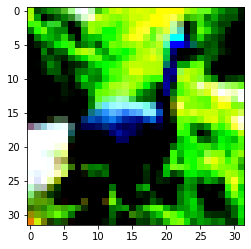

In [55]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

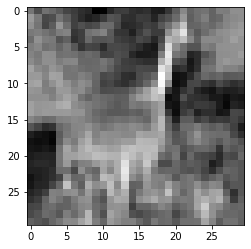

In [56]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [57]:
output.shape

torch.Size([1, 16, 30, 30])

In [58]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [59]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [60]:
with torch.no_grad():
    conv.bias.zero_()

In [61]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [62]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [63]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

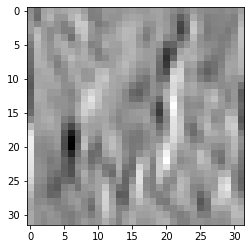

In [64]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [65]:
pool = nn.MaxPool2d(2)

In [66]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [67]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            ...)

TypeError: ellipsis is not a Module subclass

In [68]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [69]:
sum([p.numel() for p in model.parameters()])

18090

In [70]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

sum([p.numel() for p in model.parameters()])

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
sum([p.numel() for p in model.parameters()])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))